# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 144 rows (1 day), then skips 144 rows (1 day) before the next training window.

In [9]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = Path('.')
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 144    # 1 day of 10-minute samples
GAP = 0            # no skip between train and test blocks
from xgboost import XGBRegressor


In [10]:
# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = DATA_DIR / "micro_climate_rh_t_et0.xlsx"

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Convert numeric columns
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Robust parse for micro timestamps (handles mixed formats)
micro_ts_raw = micro["timestamp_dayfirst"].astype(str).str.replace("‏", "", regex=False).str.strip()
micro_ts = micro_ts_raw.apply(lambda x: pd.to_datetime(x, dayfirst=True, errors="coerce"))
unparsed = micro_ts.isna().sum()
if unparsed:
    print(f"Warning: {unparsed} micro rows had unparsable timestamps; dropping them")
micro = micro.assign(timestamp=micro_ts).dropna(subset=["timestamp"])

# Ensure micro is sorted and truncated to the expected campaign window
micro = micro.sort_values("timestamp").reset_index(drop=True)
expected_start = pd.Timestamp("2025-05-29 01:00:00")
micro = micro[micro["timestamp"] >= expected_start].reset_index(drop=True)

# Parse weather/radiation timestamps
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()


(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [11]:
# Align all sources on timestamp; keep micro as the spine to avoid dropping target rows when weather/radiation are missing
target_cols = ["internal_air_temp_c", "internal_rh_pct", "ET0", "internal_radiation"]
merged = micro.merge(weather, on="timestamp", how="left").merge(radiation, on="timestamp", how="left")
missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))
# Reindex to a continuous 10-minute grid using the micro (target) span; fill only exogenous columns
full_range = pd.date_range(micro["timestamp"].min(), micro["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()
exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()
# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")
# Time-of-day features
data["hour_frac"] = data["timestamp"].dt.hour + data["timestamp"].dt.minute/60
data["tod_sin"] = np.sin(2 * np.pi * data["hour_frac"] / 24)
data["tod_cos"] = np.cos(2 * np.pi * data["hour_frac"] / 24)
# RH anomaly and radiation ramp removed (rolling stats removed)
# Day/night indicator
data["is_night"] = data["timestamp"].dt.hour.isin([0,1,2,3,4,5,20,21,22,23]).astype(int)
feature_cols = [c for c in data.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
data.head()


diffuse_rad_wm2          0.929145
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 16,682
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,vpd_ext,abs_humidity_ext,dew_point_ext,diffuse_rad_wm2,global_rad_wm2,direct_rad_wm2,hour_frac,tod_sin,tod_cos,is_night
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,0.764606,13.122172,15.4,0.0,0.0,0.0,1.000000,0.258819,0.965926,1
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,0.759937,13.046358,15.3,0.0,0.0,0.0,1.166667,0.300706,0.953717,1
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,0.755292,12.970923,15.2,0.0,0.0,0.0,1.333333,0.342020,0.939693,1
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,0.800717,12.527413,14.7,0.0,0.0,0.0,1.500000,0.382683,0.923880,1
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,0.746077,12.821185,15.0,0.0,0.0,0.0,1.666667,0.422618,0.906308,1


In [12]:
# Define model and expanding walk-forward routine
base_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.03,
    min_child_weight=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.1,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

def features_for_target(target):
    return feature_cols

def walk_forward(df, feature_cols, target_cols, model, train_window=TRAIN_WINDOW, test_window=TEST_WINDOW, gap=GAP):
    """Expanding-window walk-forward: grow train set by each test block."""
    metrics = []
    preds = []
    train_end = train_window
    test_end = train_end + test_window
    run = 0

    while test_end <= len(df):
        train = df.iloc[:train_end]
        test = df.iloc[train_end:test_end]

        preds_run = {}
        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }

        for t_col in target_cols:
            feat_cols_t = features_for_target(t_col)
            model_t = clone(model)
            model_t.fit(train[feat_cols_t], train[t_col])
            pred_t = model_t.predict(test[feat_cols_t])
            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)
        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )

        print(
            f"Run {run}: train {metric['train_rows']} rows ({metric['train_start']} -> {metric['train_end']}), "
            f"test {metric['test_rows']} rows ({metric['test_start']} -> {metric['test_end']})"
        )
        for t_col in target_cols:
            print(
                f"  {t_col}: MAE={metric[f'mae_{t_col}']:.4f}, R2={metric[f'r2_{t_col}']:.4f}"
            )

        run += 1
        train_end += test_window  # expand training window by one test block (1 day)
        test_end = train_end + test_window

    if not metrics:
        raise ValueError("Not enough data for a single walk-forward run; check window sizes.")

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)


In [13]:

metrics_df, preds_df = walk_forward(data, feature_cols, target_cols, base_estimator)
display(metrics_df)

# Build a tidy summary: rows = variables (+ overall), cols = mae/r2
avg_mae = metrics_df[[c for c in metrics_df.columns if c.startswith("mae_")]].mean()
avg_r2 = metrics_df[[c for c in metrics_df.columns if c.startswith("r2_")]].mean()
summary_rows = []
for t in target_cols:
    summary_rows.append({"variable": t, "mae": avg_mae[f"mae_{t}"], "r2": avg_r2[f"r2_{t}"]})
summary_rows.append({"variable": "overall_mean", "mae": avg_mae.mean(), "r2": avg_r2.mean()})
summary = pd.DataFrame(summary_rows)[["variable", "mae", "r2"]]
display(summary)

# Optional: save for later analysis
# metrics_df.to_csv("walk_forward_metrics.csv", index=False)
# preds_df.to_csv("walk_forward_predictions.csv", index=False)


Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_air_temp_c: MAE=0.5469, R2=0.9704
  internal_rh_pct: MAE=5.2674, R2=0.5553
  ET0: MAE=0.0349, R2=0.9280
  internal_radiation: MAE=33.0949, R2=0.9229
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_air_temp_c: MAE=0.4346, R2=0.9777
  internal_rh_pct: MAE=1.8295, R2=0.9314
  ET0: MAE=0.0262, R2=0.9678
  internal_radiation: MAE=22.2166, R2=0.9718
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_air_temp_c: MAE=0.3966, R2=0.9845
  internal_rh_pct: MAE=3.3836, R2=0.8555
  ET0: MAE=0.0269, R2=0.9693
  internal_radiation: MAE=23.0731, R2=0.9758
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  intern

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_air_temp_c,r2_internal_air_temp_c,mae_internal_rh_pct,r2_internal_rh_pct,mae_ET0,r2_ET0,mae_internal_radiation,r2_internal_radiation
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,0.546854,0.970363,5.267398,0.555289,0.034911,0.927956,33.094859,0.922853
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,0.434592,0.977687,1.829453,0.931364,0.026182,0.967792,22.216634,0.971845
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,0.396616,0.984545,3.383643,0.855470,0.026889,0.969300,23.073078,0.975806
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,0.374337,0.988826,2.354930,0.894904,0.024609,0.975000,29.612709,0.940657
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,0.392099,0.983179,2.312705,0.926301,0.028437,0.964267,35.849969,0.929217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,2025-05-29 01:00:00,2025-09-16 02:40:00,2025-09-16 02:50:00,2025-09-17 02:40:00,15840,144,1.231911,0.805398,6.602563,0.440163,0.047343,0.724902,43.000901,0.805530
101,101,2025-05-29 01:00:00,2025-09-17 02:40:00,2025-09-17 02:50:00,2025-09-18 02:40:00,15984,144,1.078224,0.901803,7.462646,0.586419,0.035013,0.847015,32.266925,0.895276
102,102,2025-05-29 01:00:00,2025-09-18 02:40:00,2025-09-18 02:50:00,2025-09-19 02:40:00,16128,144,0.707407,0.950840,8.142678,-0.508195,0.038679,0.848978,43.620629,0.860219
103,103,2025-05-29 01:00:00,2025-09-19 02:40:00,2025-09-19 02:50:00,2025-09-20 02:40:00,16272,144,0.643380,0.936467,2.520758,0.851507,0.035983,0.834372,34.262755,0.881098


,variable,mae,r2
0,internal_air_temp_c,0.416579,0.974124
1,internal_rh_pct,2.748757,0.820073
2,ET0,0.024913,0.959303
3,internal_radiation,21.060916,0.968843
4,overall_mean,6.062791,0.930586


C:\Users\User\AppData\Local\Temp\ipykernel_11744\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


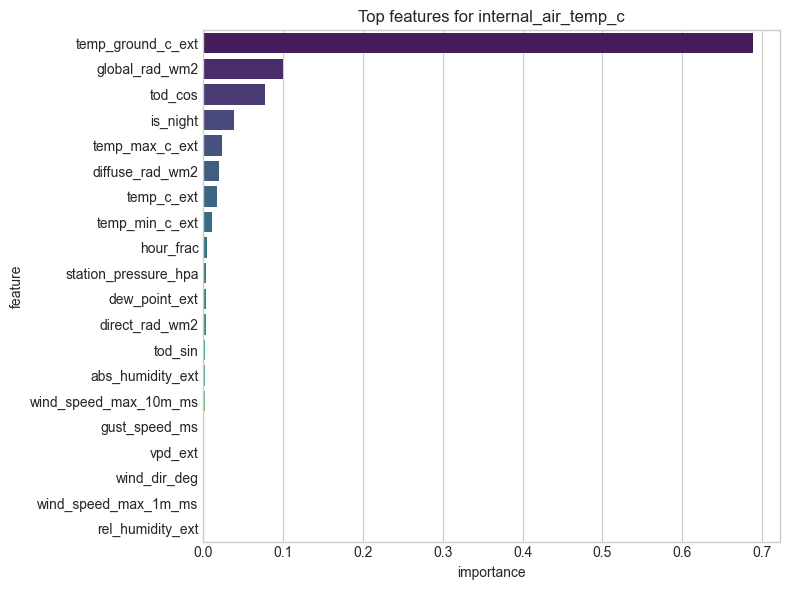

C:\Users\User\AppData\Local\Temp\ipykernel_11744\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


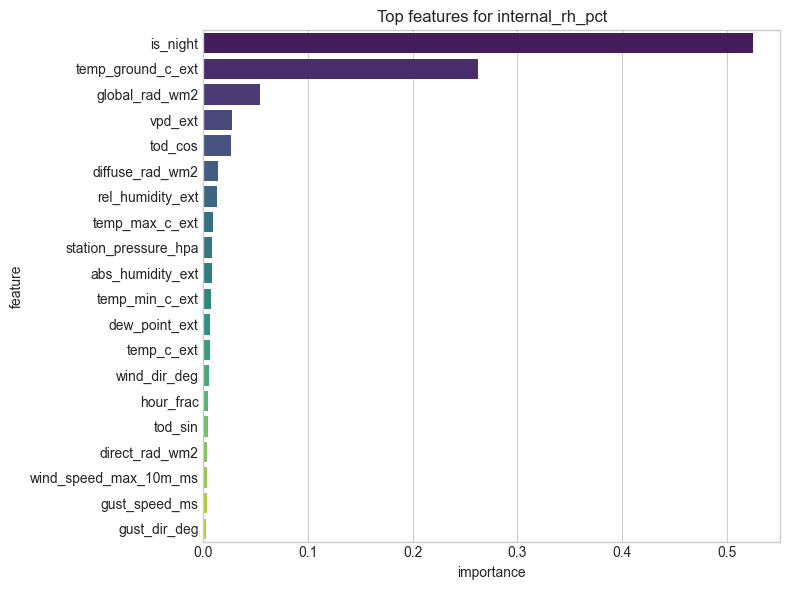

C:\Users\User\AppData\Local\Temp\ipykernel_11744\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


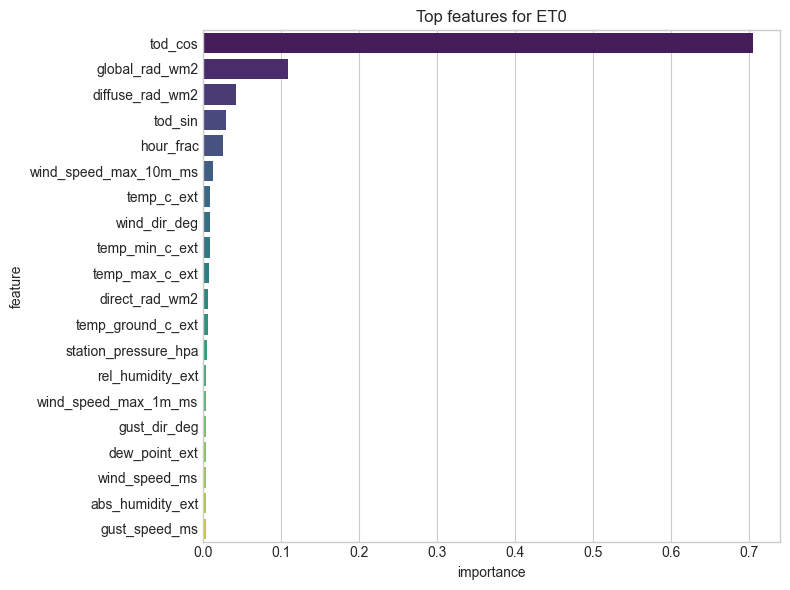

C:\Users\User\AppData\Local\Temp\ipykernel_11744\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


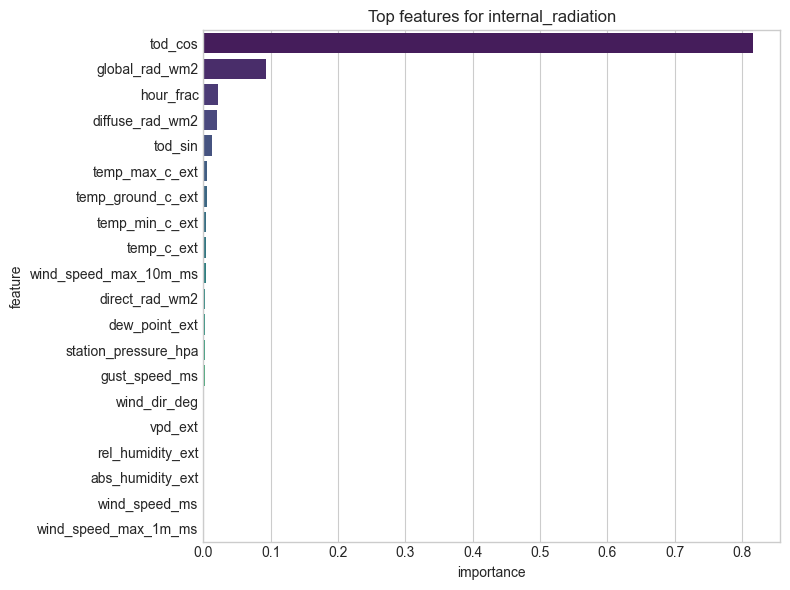

In [14]:

# Feature importance per target (trained once on full dataset)
imp_rows = []
for target in target_cols:
    feat_cols_t = features_for_target(target)
    model_t = clone(base_estimator)
    model_t.fit(data[feat_cols_t], data[target])
    fi = getattr(model_t, 'feature_importances_', None)
    if fi is None:
        print(f'No native feature_importances_ for target {target}; skipping')
        continue
    imp_rows.append(pd.DataFrame({'feature': feat_cols_t, 'importance': fi, 'target': target}))

if len(imp_rows) == 0:
    print('No feature importances available for this model type/version.')
else:
    importance_df = pd.concat(imp_rows, ignore_index=True)
    for target in target_cols:
        sub = importance_df[importance_df['target'] == target].sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(8, 6))
        sns.barplot(x='importance', y='feature', data=sub, palette='viridis')
        plt.title(f'Top features for {target}')
        plt.tight_layout()
        plt.show()


Will plot runs: [65, 68, 69, 70, 80, 81, 82, 95, 96, 100, 102]


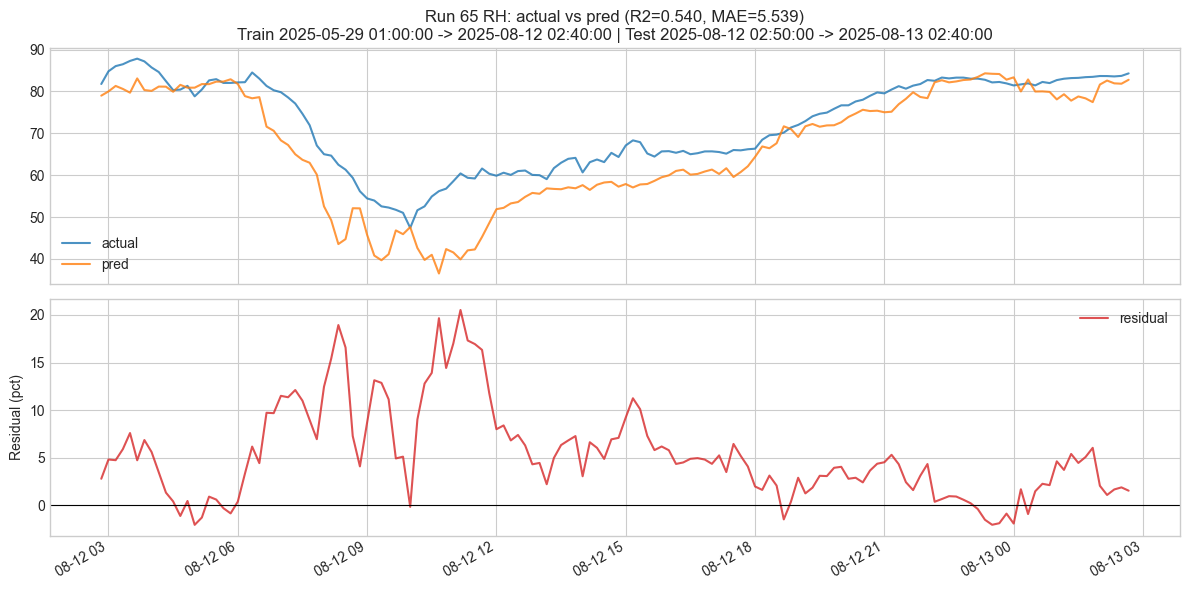

Run 65: test rows=144, gaps>10min=0, large RH jumps(>5pct)=0


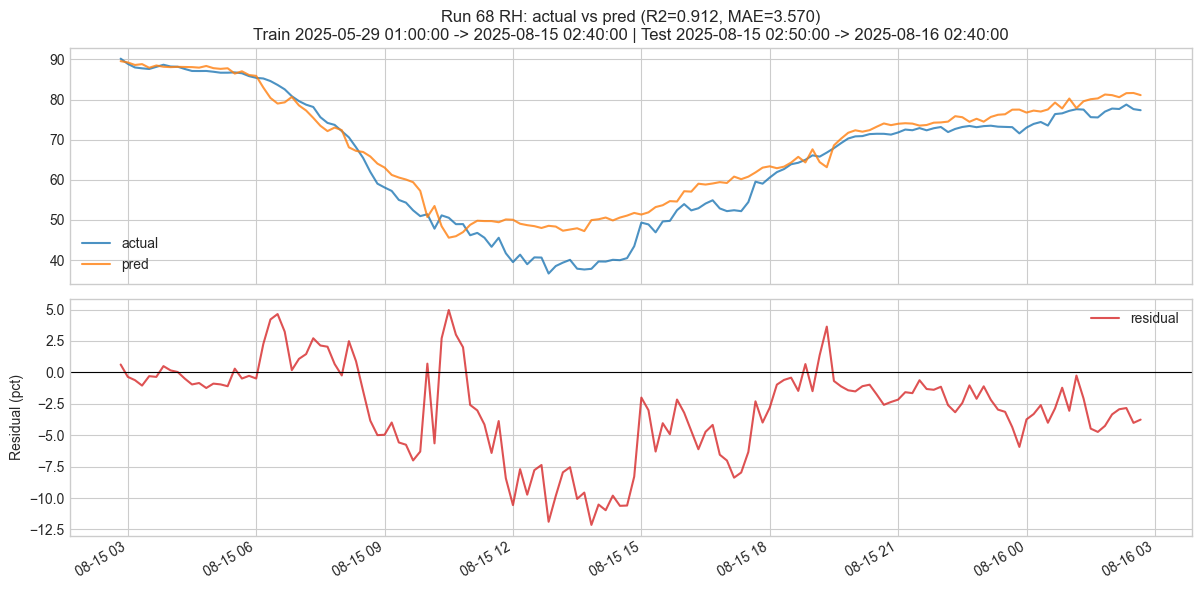

Run 68: test rows=144, gaps>10min=0, large RH jumps(>5pct)=2


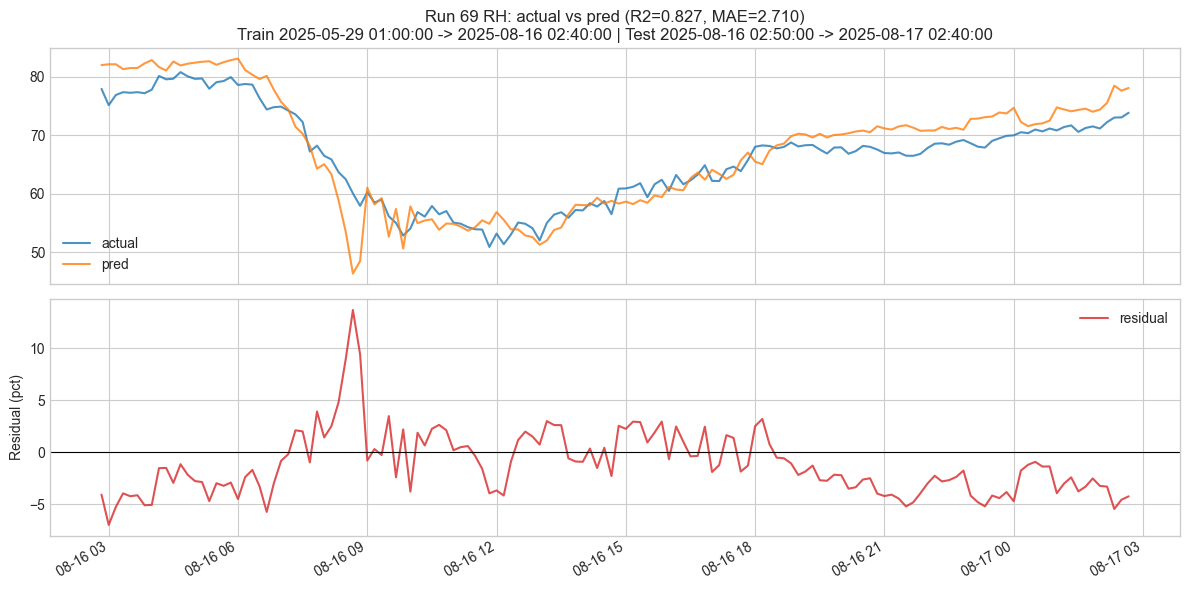

Run 69: test rows=144, gaps>10min=0, large RH jumps(>5pct)=1


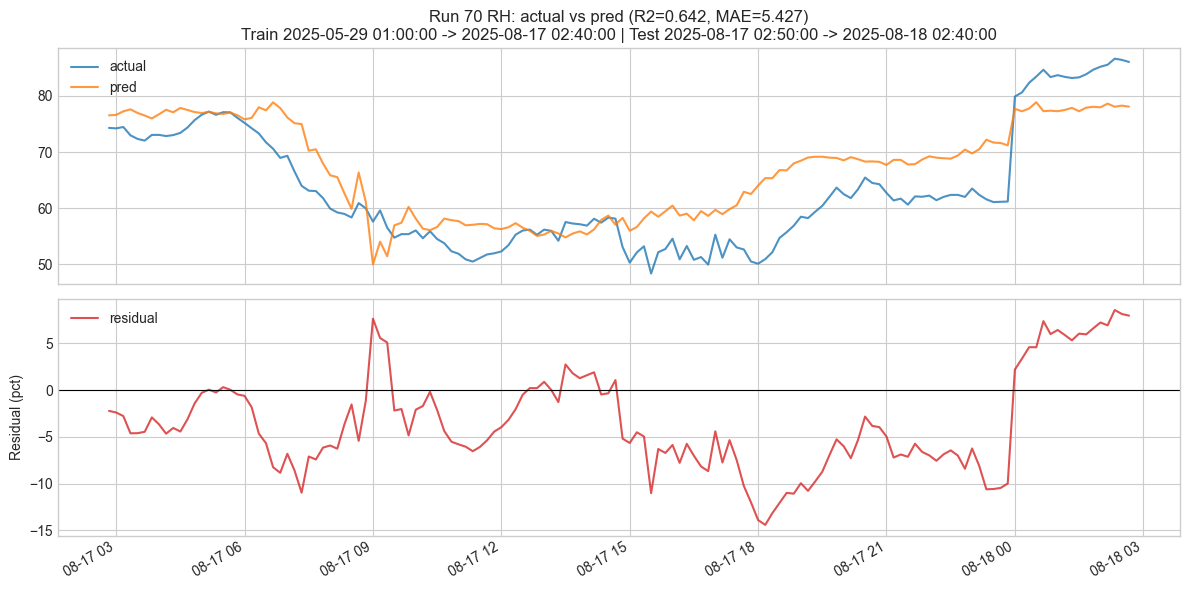

Run 70: test rows=144, gaps>10min=0, large RH jumps(>5pct)=3


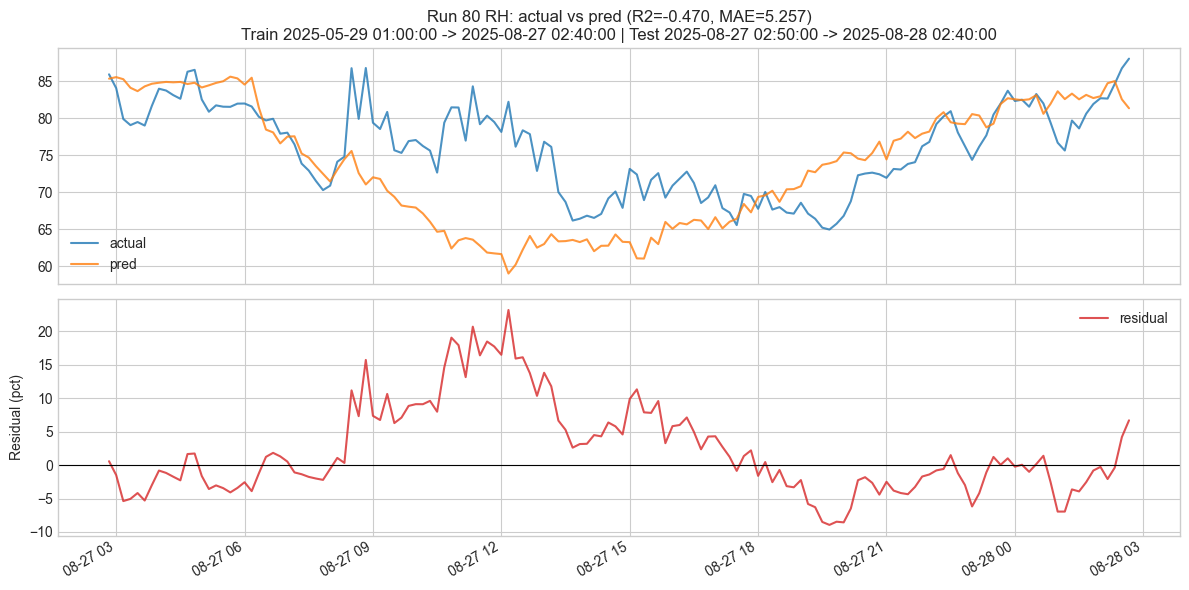

Run 80: test rows=144, gaps>10min=0, large RH jumps(>5pct)=11


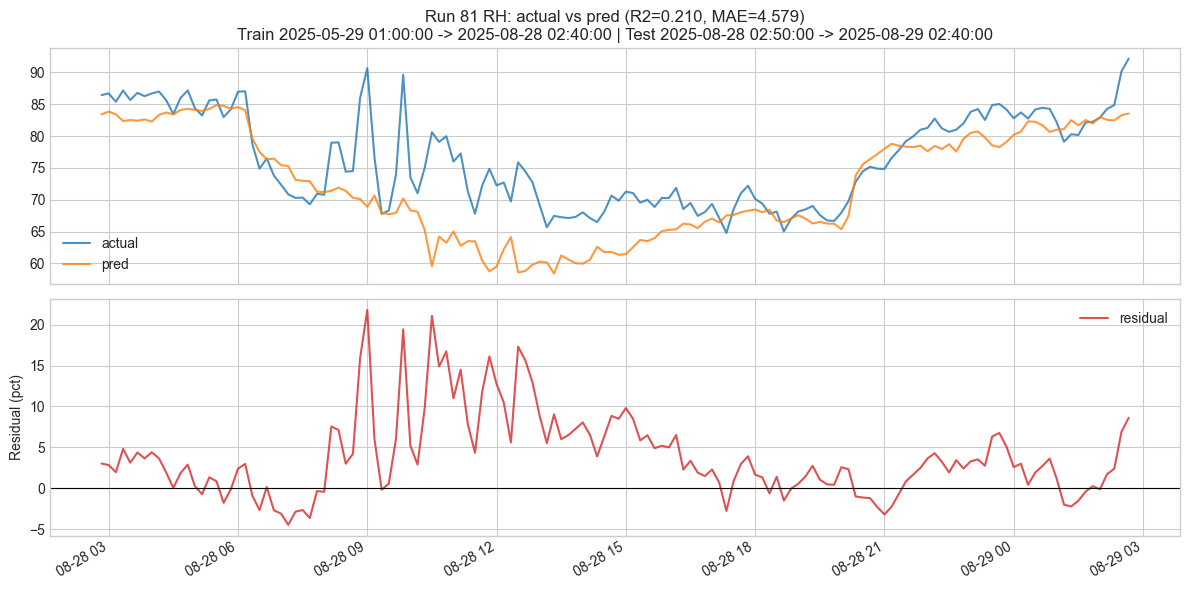

Run 81: test rows=144, gaps>10min=0, large RH jumps(>5pct)=12


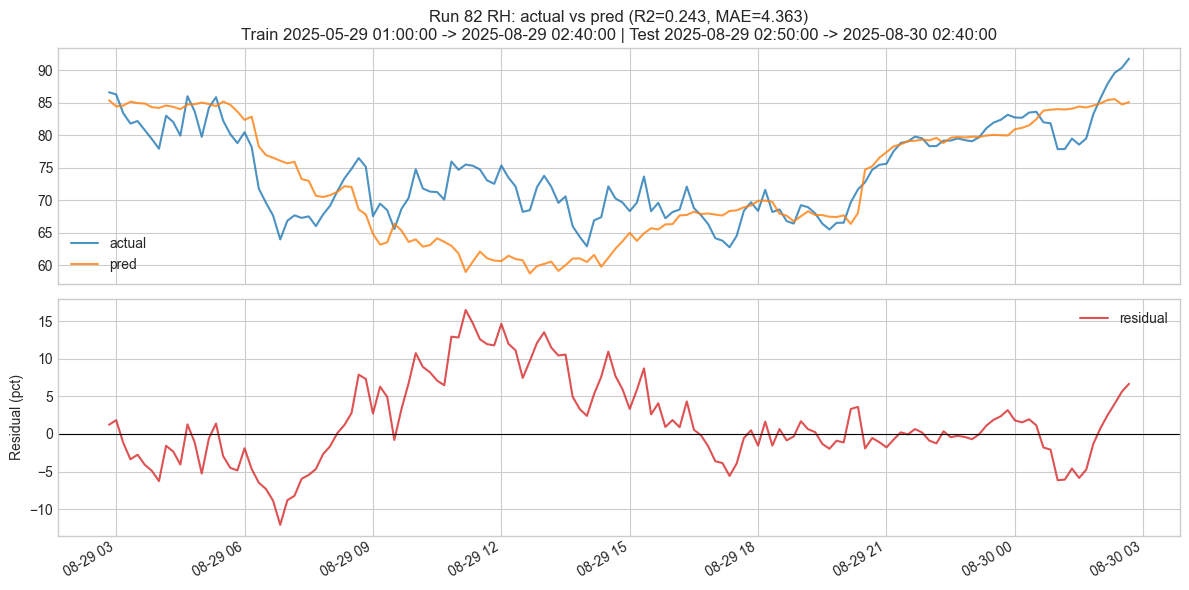

Run 82: test rows=144, gaps>10min=0, large RH jumps(>5pct)=6


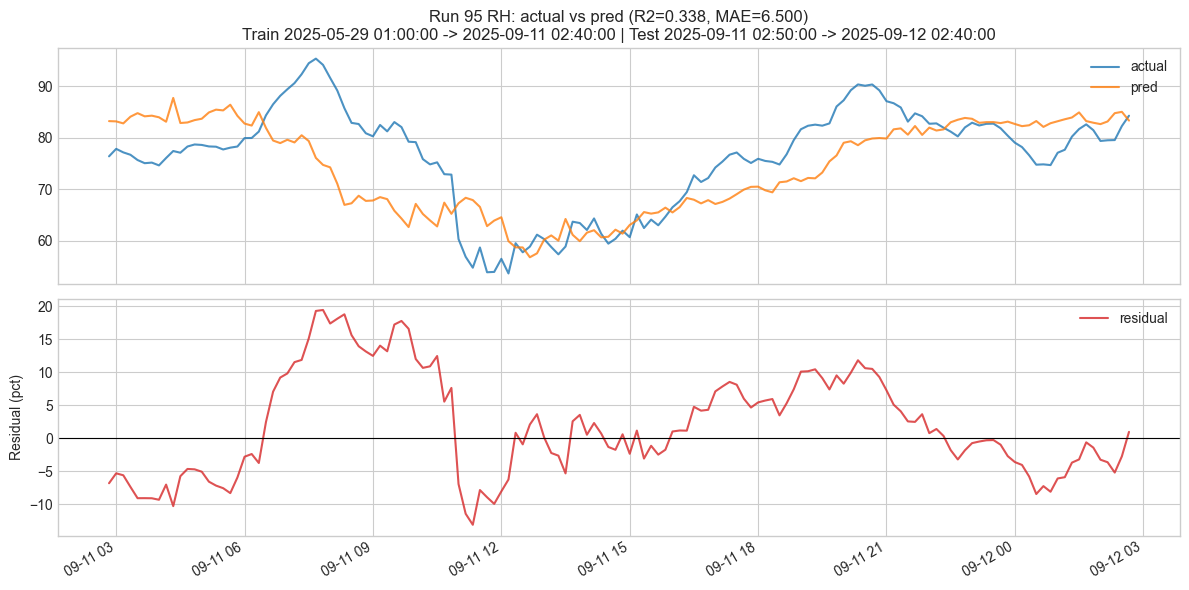

Run 95: test rows=144, gaps>10min=0, large RH jumps(>5pct)=2


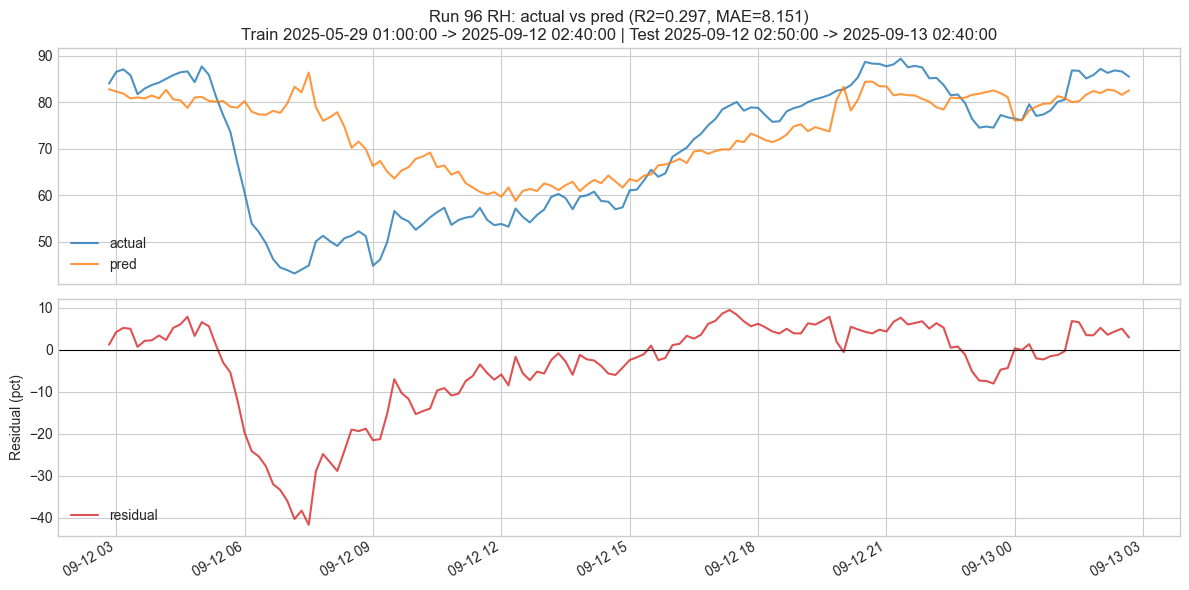

Run 96: test rows=144, gaps>10min=0, large RH jumps(>5pct)=7


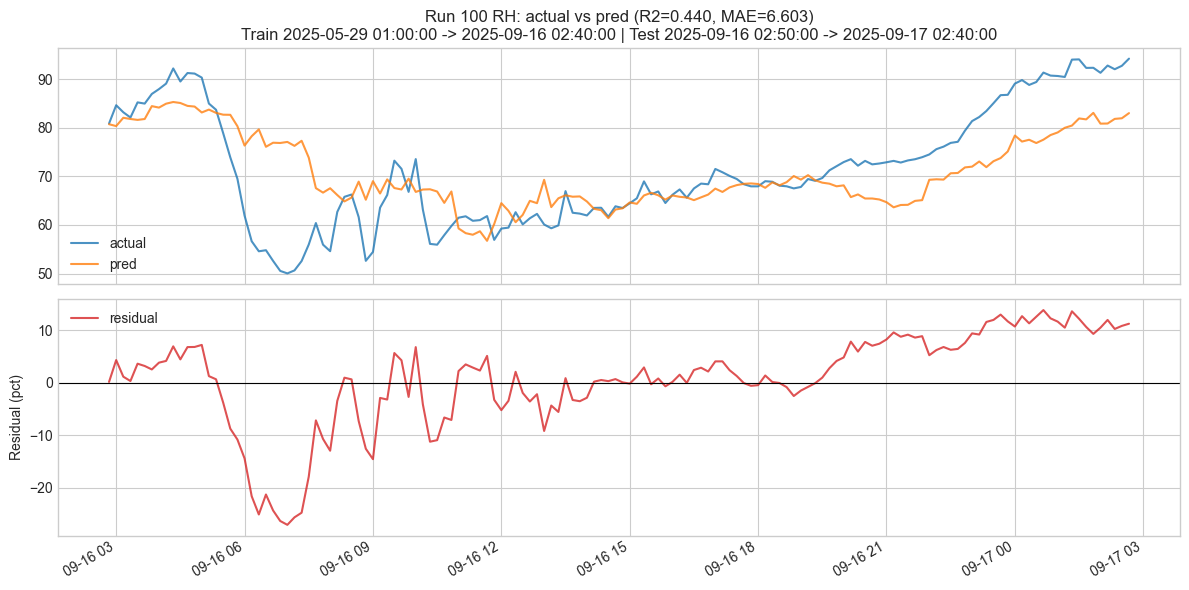

Run 100: test rows=144, gaps>10min=0, large RH jumps(>5pct)=11


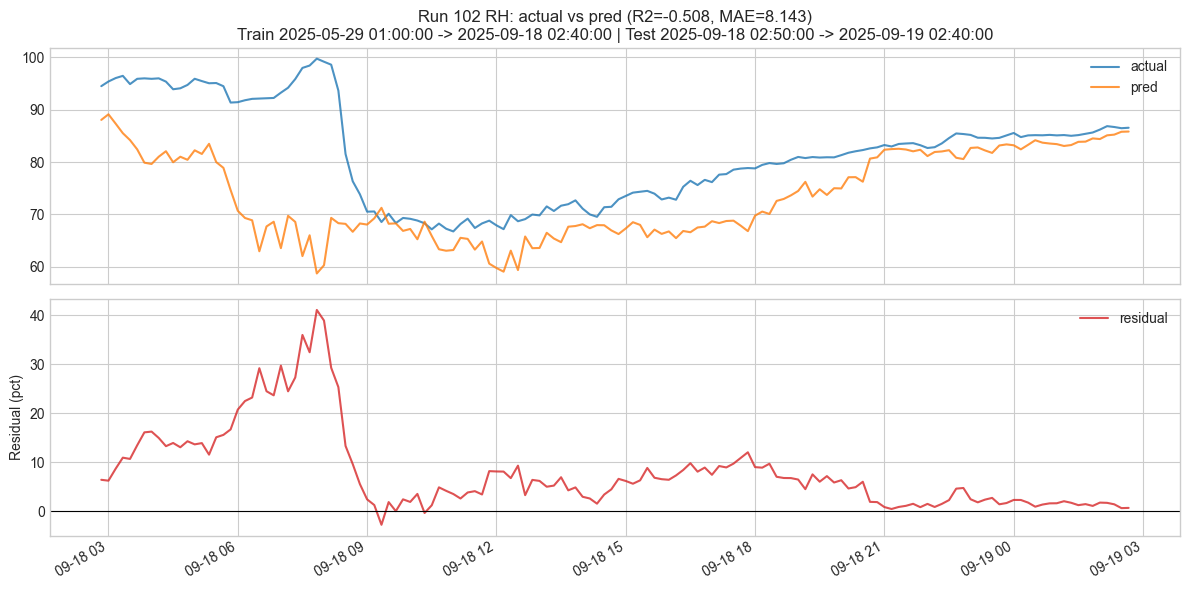

Run 102: test rows=144, gaps>10min=0, large RH jumps(>5pct)=2


In [15]:
# Diagnostics: RH actual vs pred and residuals for low R2 runs
# Identify worst runs for RH and plot time-series
rh_target = "internal_rh_pct"
r2_col = f"r2_{rh_target}"
mae_col = f"mae_{rh_target}"

runs_of_interest = [68, 69, 70]  # tweak as needed
bad_runs = metrics_df.sort_values(r2_col).head(8)["run"].tolist()
runs_to_plot = sorted(set(runs_of_interest + bad_runs))
print(f"Will plot runs: {runs_to_plot}")


def plot_rh_diagnostics(run_ids):
    for r in run_ids:
        meta = metrics_df.loc[metrics_df["run"] == r]
        if meta.empty:
            print(f"Run {r} not found in metrics_df; skipping")
            continue
        meta = meta.iloc[0]
        sub = preds_df[preds_df["run"] == r].copy()
        if sub.empty:
            print(f"No predictions for run {r}; skipping")
            continue
        sub["residual"] = sub[rh_target] - sub[f"pred_{rh_target}"]

        fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
        axes[0].plot(sub["timestamp"], sub[rh_target], label="actual", alpha=0.8)
        axes[0].plot(sub["timestamp"], sub[f"pred_{rh_target}"], label="pred", alpha=0.8)
        axes[0].set_title(
            f"Run {r} RH: actual vs pred (R2={meta[r2_col]:.3f}, MAE={meta[mae_col]:.3f})\n"
            f"Train {meta['train_start']} -> {meta['train_end']} | Test {meta['test_start']} -> {meta['test_end']}"
        )
        axes[0].legend()

        axes[1].plot(sub["timestamp"], sub["residual"], label="residual", color="tab:red", alpha=0.8)
        axes[1].axhline(0, color="k", lw=0.8)
        axes[1].set_ylabel("Residual (pct)")
        axes[1].legend()
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()

        # Simple data-quality stats in the test window
        window = data[(data["timestamp"] >= meta["test_start"]) & (data["timestamp"] <= meta["test_end"])].copy()
        diffs = window[rh_target].diff().abs()
        gap_count = (window["timestamp"].diff() > pd.Timedelta("10min")).sum()
        big_jumps = (diffs > 5).sum()
        print(
            f"Run {r}: test rows={len(window)}, gaps>10min={gap_count}, large RH jumps(>5pct)={big_jumps}"
        )


plot_rh_diagnostics(runs_to_plot)
